In [1]:
%load_ext autoreload
%autoreload 2
from MVC_env import MVC_environement
from DQN_network import embedding_network

import numpy as np
import networkx as nx
import math
import torch
from tqdm import tqdm_notebook as tqdm
import pickle
import warnings
warnings.filterwarnings("ignore")

def pickle_save(data,file_name):
    with open(file_name,'wb') as f:
        pickle.dump(data , f)
def pickle_load(file_name):
    with open(file_name,'rb') as f:
        return pickle.load(f)



In [2]:
import numpy as np
from collections import namedtuple

experience = namedtuple("experience" , ['graph','Xv','action','reward','next_Xv','is_done'])

class replay_buffer():
    def __init__(self , max_size):
        self.buffer = np.zeros(  [max_size],dtype = experience)
        self.max_size = max_size
        self.size = 0
        self.idx = -1
    def push(self , new_exp):
        if(self.size >= self.max_size):
            self.idx = (self.idx+1) % self.max_size
        else:
            self.idx = self.idx + 1
            self.size += 1
        
        self.buffer[self.idx] = new_exp
    
    def sample(self , batch_size):
        batch = np.random.choice(np.arange(self.size) , size = batch_size , replace=False)
        
        return self.buffer[[batch]]
    


In [3]:
def approximate_algo(env):
    edge_list = env.edges[:]
    
    C =  set()
    #print(len(edge_list))
    while( len(edge_list) > 0):
        #print(len(edge_list))
        e = edge_list[-1]
        u,v = e
        C.add(u)
        C.add(v)
        to_remove = []
        for ed in edge_list:
            if (u in ed) or (v in ed):
                to_remove.append(ed)
        for ed in to_remove:
            edge_list.remove(ed)
    
    for v in C:
        env.take_action(v)
    
    return C
    
    
g = nx.erdos_renyi_graph(n = 200 , p = 0.15)
#g = nx.barabasi_albert_graph(n=100,m=10)
env = MVC_environement(g)
C = approximate_algo(env)
len(C)

196

In [4]:
graph_size = 20
validation_graph = []
for i in range(50):
    #p = np.random.uniform(0.05,0.)
    g = nx.erdos_renyi_graph(n = graph_size , p = 0.15)
    #g = nx.barabasi_albert_graph()
    validation_graph.append(g)

In [5]:
res = []
for g in validation_graph:
    env = MVC_environement(g)
    C = approximate_algo(env)
    res.append(len(C))
sum(res)/len(res)

15.68

In [6]:
def validation(dqn , validation_graph):
    objective_vals = []
    for g in validation_graph:
        env = MVC_environement(g)
        Xv , graph = env.reset_env()
        graph = torch.unsqueeze(graph,  0)
        Xv = Xv.clone()
        #Xv = Xv.cuda()
        #graph = graph.cuda()
        done = False
        non_selected = list(np.arange(env.num_nodes))
        selected = []
        while done == False:
            #Xv = Xv.cuda()
            val = dqn(graph , Xv)[0]
            val[selected] = -999999
            action = int(torch.argmax(val).item())
            Xv_next , reward , done = env.take_action(action)
            Xv_next = Xv_next.clone()
            non_selected.remove(action)
            selected.append(action)
            Xv = Xv_next
        objective_vals.append(len(selected))
    return sum(objective_vals)/len(objective_vals)

In [7]:
MAX_EPISODE = 1000
dqn = embedding_network(emb_dim=64 , T = 5).double()
target_net = embedding_network(emb_dim=64 , T = 5).double()
target_net.load_state_dict(dqn.state_dict())
EPS_START = 1.00
EPS_END = 0.05
EPS_DECAY = 20000
steps_done = 0
loss_func = torch.nn.MSELoss()
#USE_CUDA = torch.cuda.is_available()
N_STEP = 5
reward_history = []
batch_size = 128
buffer = replay_buffer(10000)
optimizer = torch.optim.Adam(dqn.parameters(),lr=0.00002)
validation_result = []
ba_result = []

for e in tqdm(range(MAX_EPISODE)):

    #p = np.random.uniform(0.05,0.3)
    p = 0.15
    g = nx.erdos_renyi_graph(n = graph_size , p = p)
    #g = validation_graph[e%len(validation_graph)]
    env = MVC_environement(g)
    Xv , graph = env.reset_env()
    Xv = Xv.clone()
    graph = torch.unsqueeze(graph,  0)
    done = False
    non_selected = list(np.arange(env.num_nodes))
    selected = []
    N = 0
    reward_list = []
    while done == False:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        
        
        if np.random.uniform() > eps_threshold:
            val = dqn(graph , Xv)[0]
            val[selected] = -999999
            action = int(torch.argmax(val).item())
        else:
            action = int(np.random.choice(non_selected))
            
        Xv_next , reward , done = env.take_action(action)
        Xv_next = Xv_next.clone()
        non_selected.remove(action)
        selected.append(action)
        N += 1 
        reward_list.append(reward)
        if N >= N_STEP:
            reward_n = sum(reward_list)
            ex = experience(graph , Xv , torch.tensor([action]) , torch.tensor([reward_n]) , Xv_next , done)
            buffer.push(ex)
            reward_list.pop(0)
        Xv = Xv_next
        
        steps_done += 1
        
        if buffer.size >= batch_size:
            batch = buffer.sample(batch_size)
            batch = experience(*zip(*batch))
            batch_graph = torch.cat(batch.graph)
            batch_state = torch.cat(batch.Xv)
            batch_action = torch.cat(batch.action)
            batch_reward = torch.cat(batch.reward).double()
            batch_next_state = torch.cat(batch.next_Xv)
            non_final_mask = torch.tensor(tuple(map(lambda s : s is not True, batch.is_done)),dtype = torch.uint8)
            
            non_final_graph = batch_graph[non_final_mask]
            non_final_next_state = batch_next_state[non_final_mask]
            
            next_state_value = torch.zeros(batch_size).detach().double()
                
            pred_q = dqn(batch_graph , batch_state ).gather(1 , batch_action.view(-1,1)).view(-1)
            
            
            next_state_value[non_final_mask] = target_net(non_final_graph , non_final_next_state).max(1)[0].detach()
            expected_q = next_state_value + batch_reward
            loss = loss_func(pred_q , expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if e > 0 and e % 15 == 0:
        target_net.load_state_dict(dqn.state_dict())
    if e % 50 == 0:
        v = validation(dqn , validation_graph)
        validation_result.append(v)

KeyboardInterrupt: 

In [8]:
torch.tensor(tuple(map(lambda s : s is not False, batch.is_done)),dtype = torch.uint8)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)

In [9]:
#torch.save(dqn.state_dict(), 'trained_model/MVC_ER_n{}.pkl'.format(graph_size))
#pickle_save(validation_result , 'validation_result/MVC_ER_n{}_ER.pkl'.format(graph_size))
#pickle_save(ba_result , 'validation_result/MVC_ER_n{}_BA.pkl'.format(graph_size))

In [10]:
import matplotlib.pyplot as plt
plt.plot(validation_result)
plt.title('Train on ER, test on ER')

Text(0.5, 1.0, 'Train on ER, test on ER')

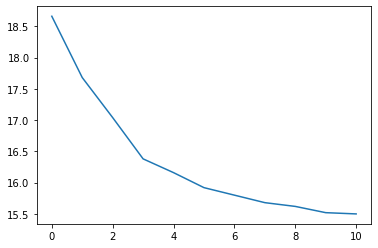

In [11]:
plt.plot(validation_result)